In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import mannwhitneyu


train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

initial_features = list(test.columns)
train

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,1,17,1,9254,1,1,121.0,1,19,1,...,0,6,8,5,10.600000,0,13.9,-0.3,0.79,Graduate
76514,1,1,6,9254,1,1,125.0,1,1,38,...,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,Graduate
76515,5,17,1,9085,1,1,138.0,1,37,37,...,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,Enrolled


## EDA


### Print the number of unique values for each column


In [12]:
for col in train.columns:
    print(f'{col} has {train[col].nunique()} values')

Marital status has 6 values
Application mode has 22 values
Application order has 8 values
Course has 19 values
Daytime/evening attendance has 2 values
Previous qualification has 21 values
Previous qualification (grade) has 110 values
Nacionality has 18 values
Mother's qualification has 35 values
Father's qualification has 39 values
Mother's occupation has 40 values
Father's occupation has 56 values
Admission grade has 668 values
Displaced has 2 values
Educational special needs has 2 values
Debtor has 2 values
Tuition fees up to date has 2 values
Gender has 2 values
Scholarship holder has 2 values
Age at enrollment has 46 values
International has 2 values
Curricular units 1st sem (credited) has 21 values
Curricular units 1st sem (enrolled) has 24 values
Curricular units 1st sem (evaluations) has 36 values
Curricular units 1st sem (approved) has 23 values
Curricular units 1st sem (grade) has 1206 values
Curricular units 1st sem (without evaluations) has 12 values
Curricular units 2nd sem

### Target distribution


C:\Users\20141\AppData\Local\Temp\ipykernel_22844\2342838711.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Target', data=train, palette='pastel')


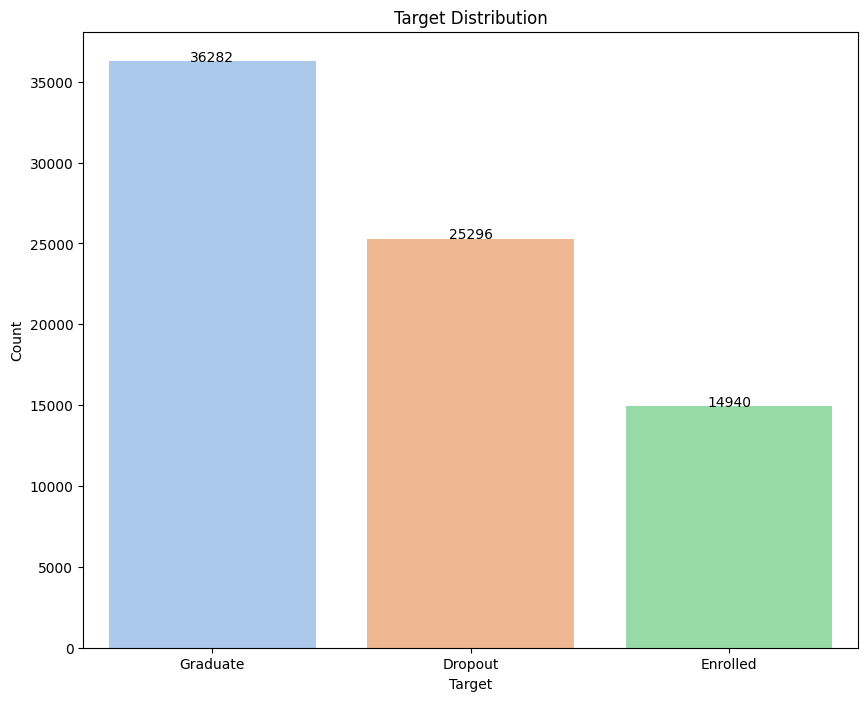

In [13]:
# Set the figure size and create a count plot
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Target', data=train, palette='pastel')

# Add labels to each bar in the plot
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center")

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

### Feature distributions


In [14]:
# カテゴリーデータを数値ではなくカテゴリーと認識させるための処理

# カテゴリーデータをセット
cat_features = ['Marital status', 'Application mode', 'Course',
                'Previous qualification', 'Nacionality', "Mother's qualification", 
                "Father's qualification", "Mother's occupation",
                "Father's occupation"]
# 上記のカラムはカテゴリーとtype付けする
for feature in cat_features:
    dtype = pd.CategoricalDtype(categories=list(set(train[feature]) | set(test[feature])), ordered=False)
    for df in [train, test]:
        df[feature] = df[feature].astype(dtype)

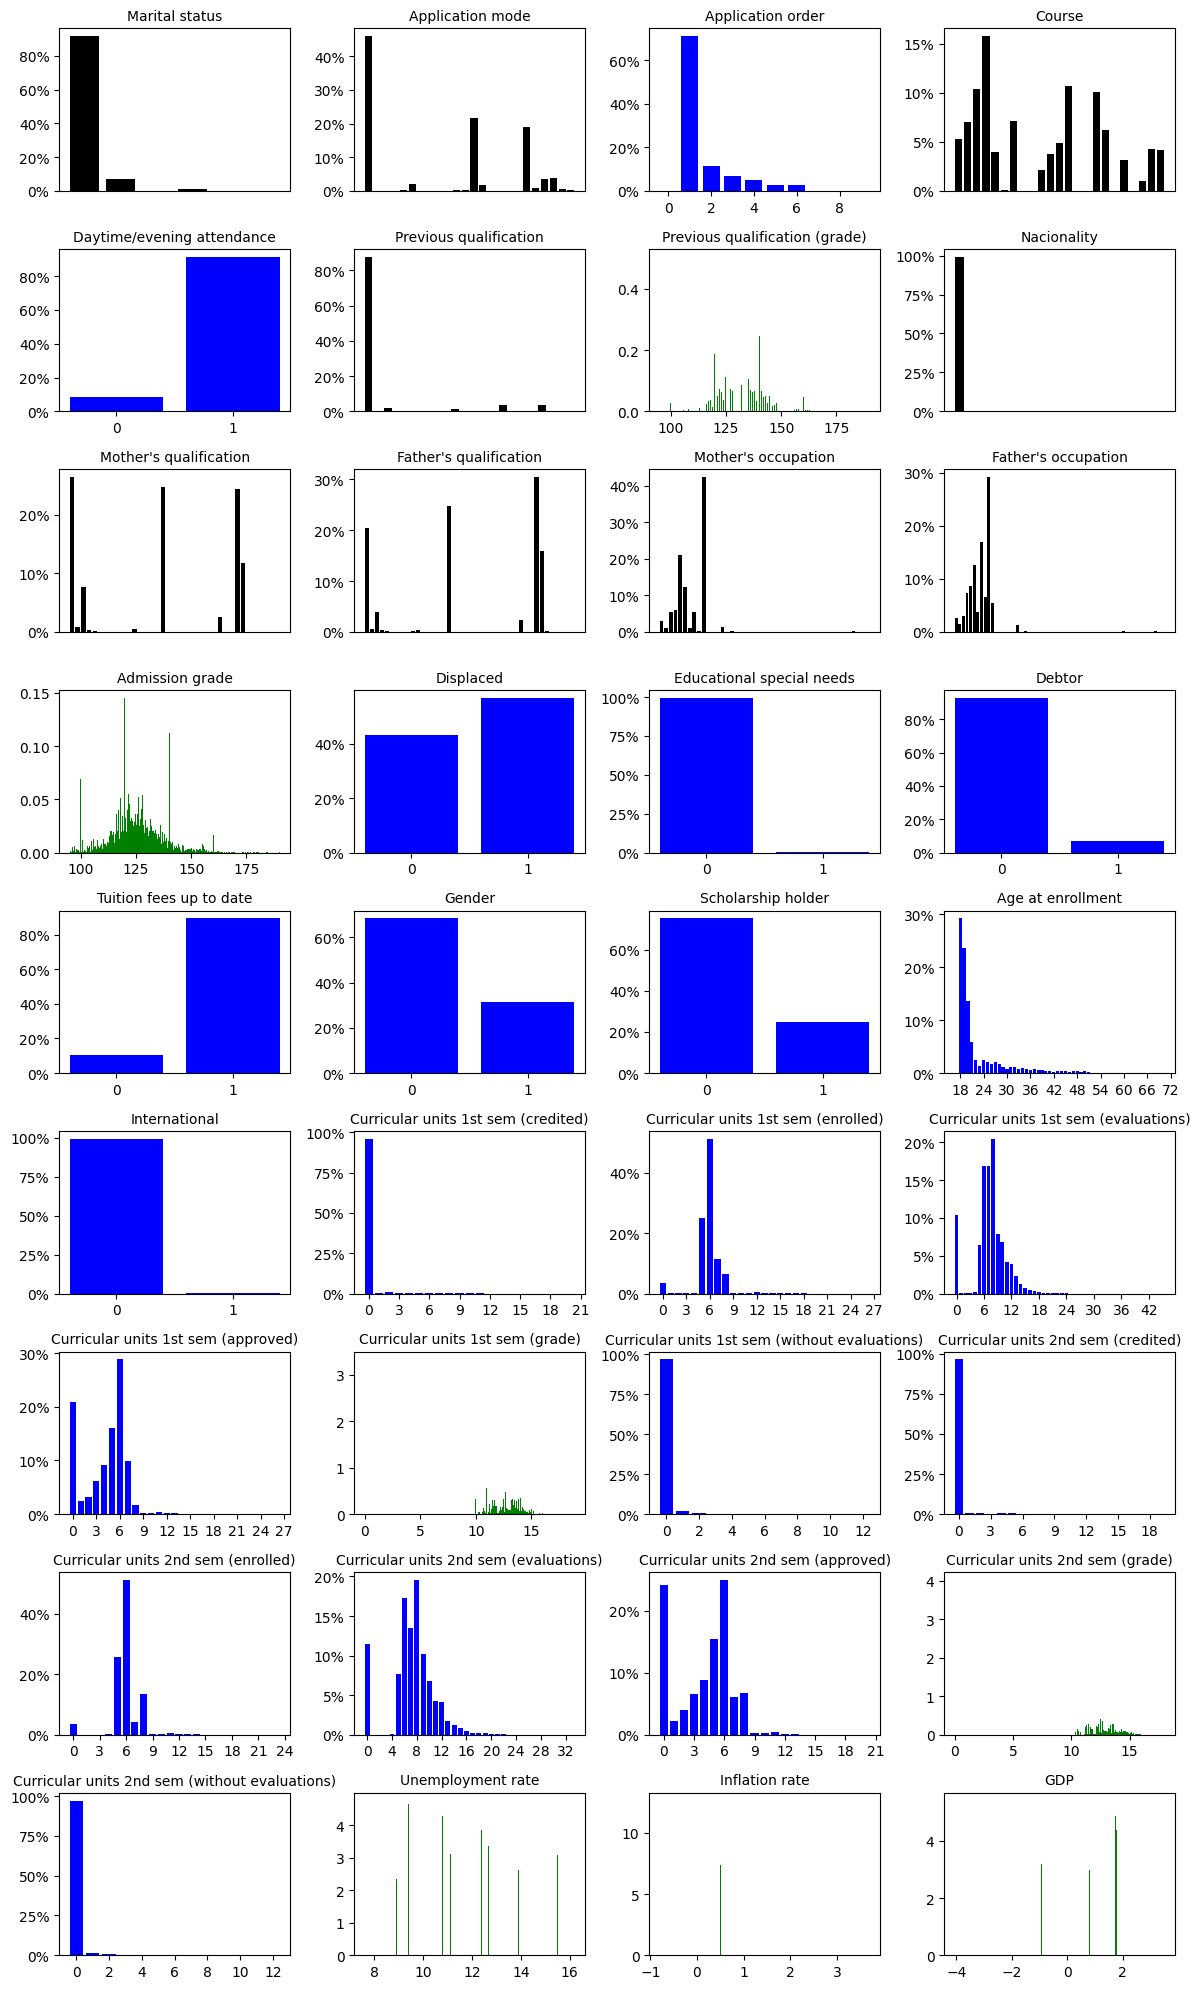

In [16]:
# 全データを可視化
# floatデータは緑ヒストグラム
# categoryデータは黒棒グラフ
# integerデータは青棒グラフ
_, axs = plt.subplots(9, 4, figsize=(12, 20))
for col, ax in zip(initial_features, axs.ravel()):
    if train[col].dtype == float:
        ax.hist(train[col], bins=300, density=True, color='g')
    elif train[col].dtype == 'category':
        vc = train[col].cat.codes.value_counts() / len(train)
        ax.bar(vc.index, vc, color='k')
        ax.yaxis.set_major_formatter('{x:.0%}')
        ax.set_xticks([])
    else: # integer
        vc = train[col].value_counts() / len(train)
        ax.bar(vc.index, vc, color='b')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter('{x:.0%}')
    ax.set_title(col, fontsize=10)
plt.tight_layout()
plt.show()

## Feature correlations


In [17]:
from sklearn.preprocessing import LabelEncoder

categories = ['dropout', 'enrolled', 'graduate']
label_encoder = LabelEncoder()

# Convert categorical 'Target' labels to numeric values using LabelEncoder
train['Target'] = label_encoder.fit_transform(train['Target'])

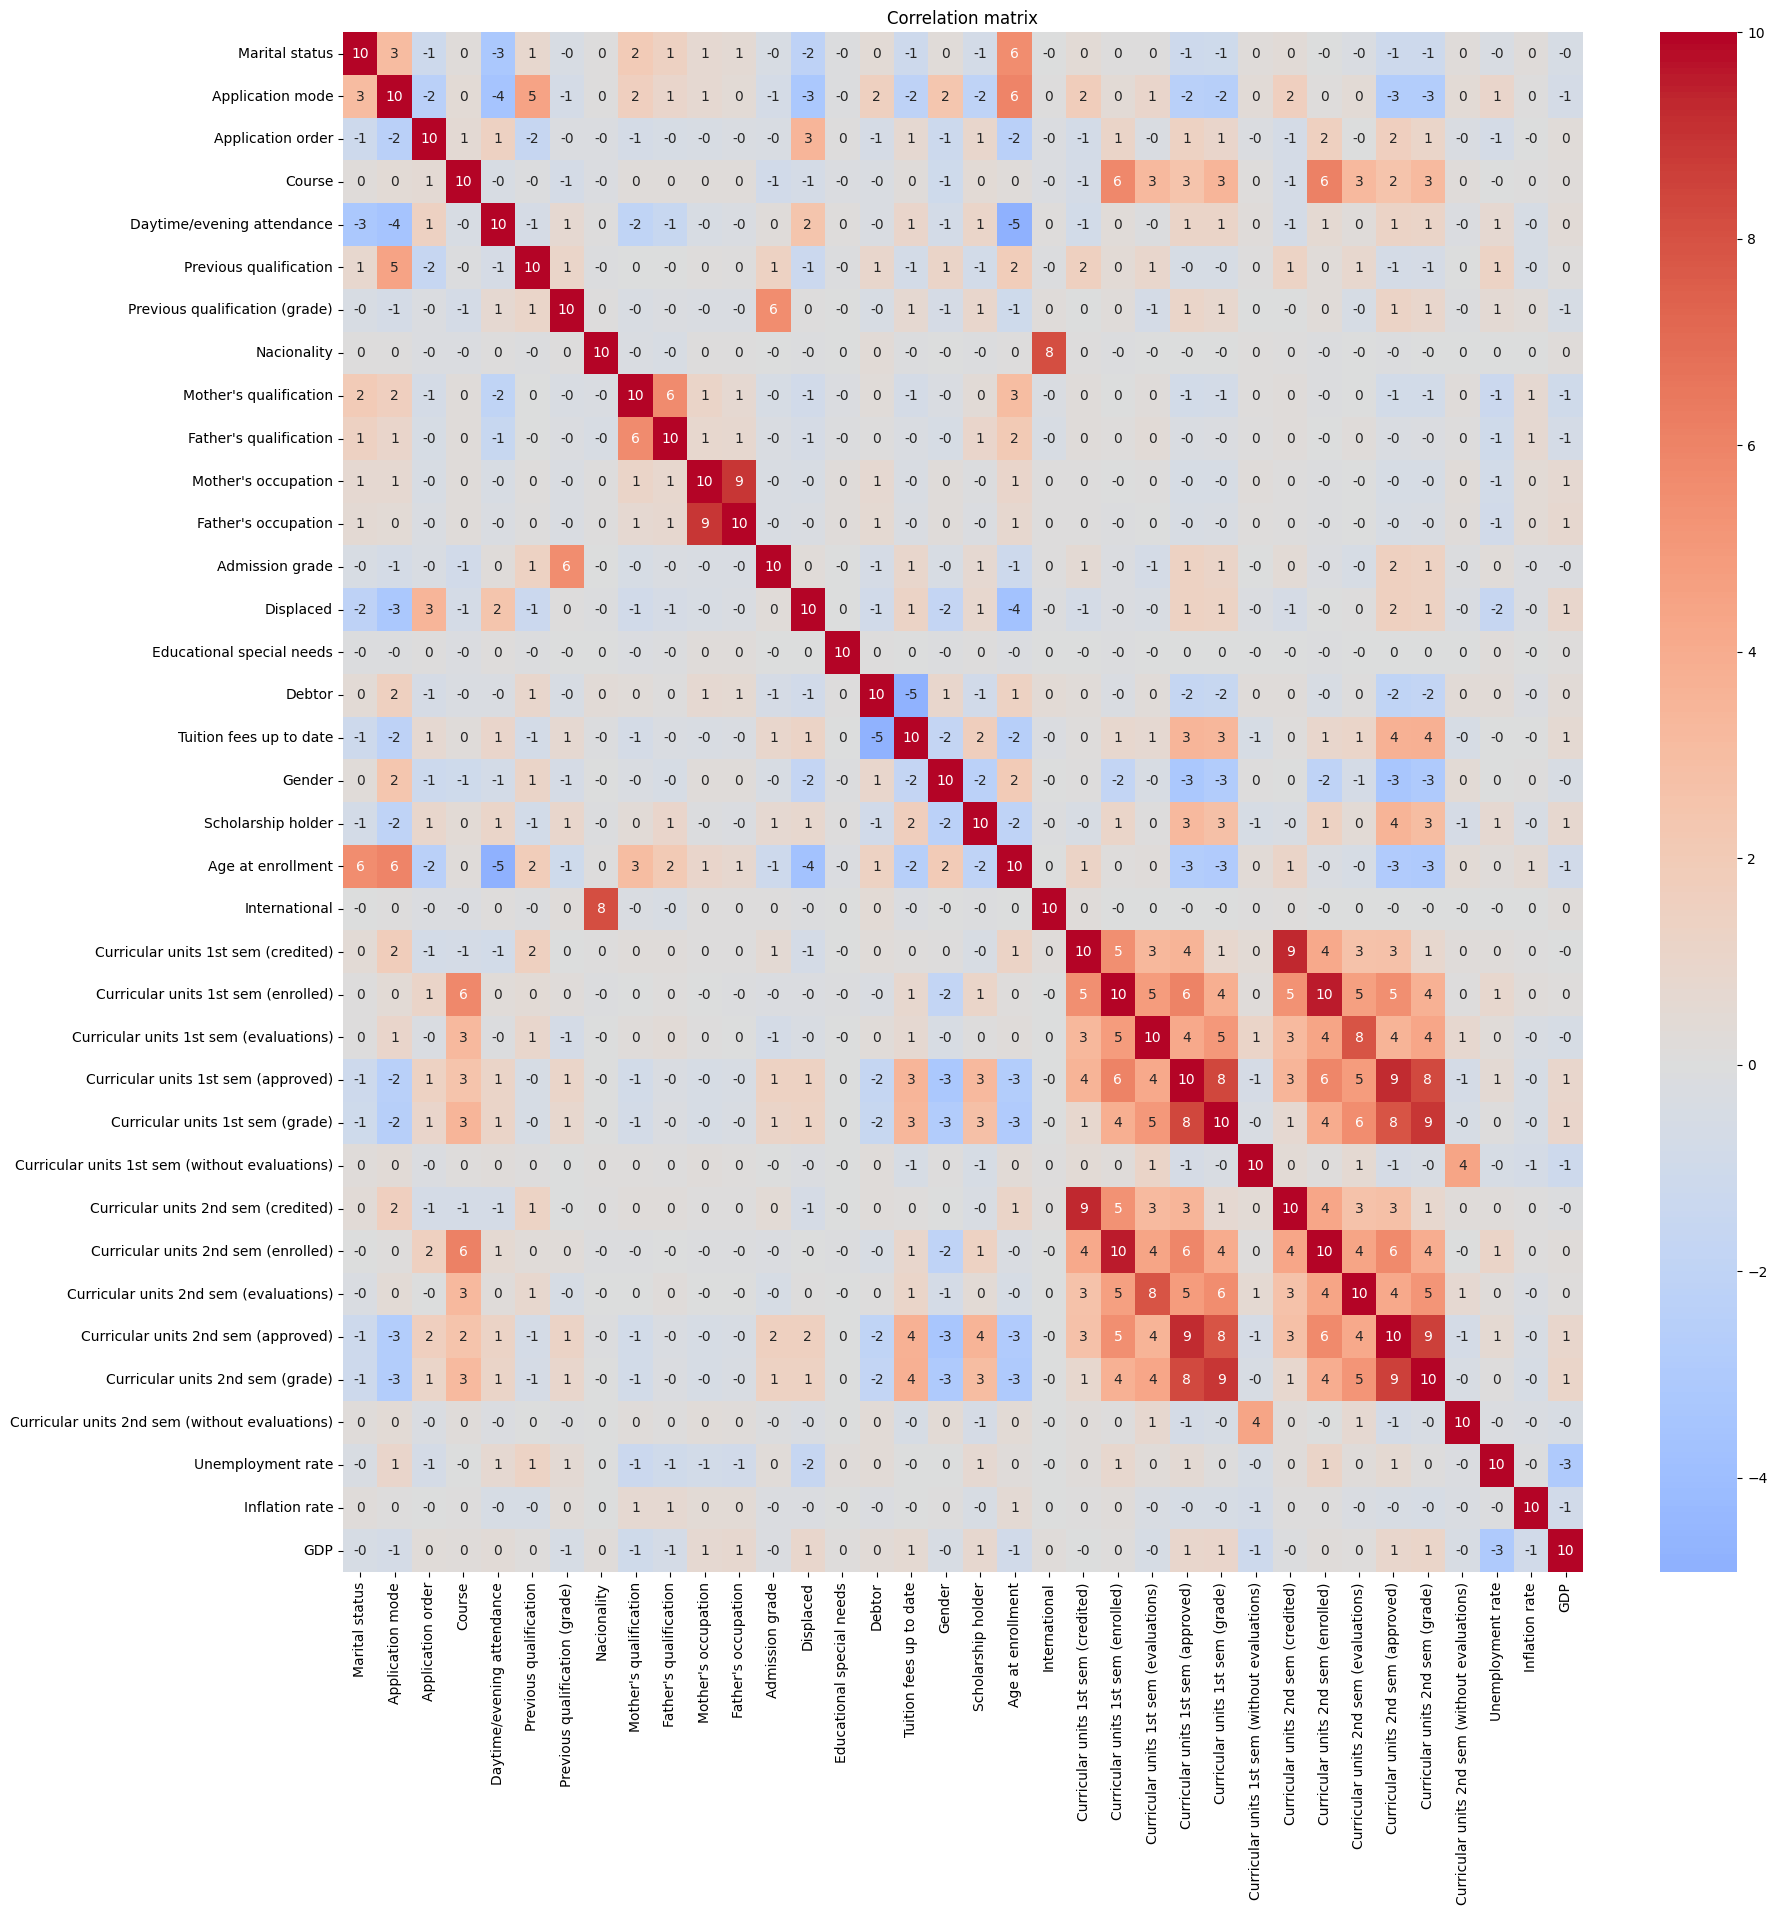

In [21]:
# 見やすさのために10倍している
corr_features = initial_features
cc = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(20, 20))
sns.heatmap(cc*10, center=0, cmap='coolwarm', annot=True, fmt='.0f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

## Comparing train and test data


In [24]:
print('\nMann–Whitney U test comparing train and test datasets')
print(mannwhitneyu(train['Curricular units 2nd sem (grade)'],
                   test['Curricular units 2nd sem (grade)']))


Mann–Whitney U test comparing train and test datasets
MannwhitneyuResult(statistic=1939815047.0, pvalue=0.06384029023546983)
